<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/diffusion/customdiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[webpage](https://huggingface.co/docs/diffusers/training/custom_diffusion)


Installation

In [ ]:
!pip install -q transformers accelerate
!pip install -q clip-retrieval
!pip install -q xformers
!git clone https://github.com/huggingface/diffusers
%cd /content/diffusers
!pip install -e .

Normalized class image generation

In [ ]:
%cd /content/diffusers/examples/custom_diffusion
!python retrieve.py --class_prompt chair --class_data_dir real_reg/samples_chair --num_class_images 100

In [ ]:
%cd /content/diffusers/examples/custom_diffusion
!python retrieve.py --class_prompt table --class_data_dir real_reg/samples_table --num_class_images 100

Multiconcept

In [ ]:
# multiconcept

%cd /content/diffusers/examples/custom_diffusion
from accelerate.utils import write_basic_config

write_basic_config()

# Multi conceptはT4では無理そう
# 現状それぞれ作成して
MODEL_NAME="SG161222/Realistic_Vision_V3.0_VAE"
OUTPUT_DIR="multicheckpoints"

!accelerate launch train_custom_diffusion.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --output_dir=$OUTPUT_DIR \
  --concepts_list=./concept_list.json \
  --with_prior_preservation --real_prior --prior_loss_weight=1.0 \
  --resolution=512  \
  --train_batch_size=1  \
  --learning_rate=1e-5  \
  --lr_warmup_steps=0 \
  --max_train_steps=2000 \
  --num_class_images=100 \
  --scale_lr --hflip  \
  --modifier_token "<new1>+<new2>"

In [1]:
# single inputだけではダメそう、、
!rm -rf /content/diffusers/examples/custom_diffusion/checkpoints

Training

In [ ]:
%cd /content/diffusers/examples/custom_diffusion
from accelerate.utils import write_basic_config

write_basic_config()

MODEL_NAME="SG161222/Realistic_Vision_V3.0_VAE"
OUTPUT_DIR="checkpoints"
INSTANCE_DIR="./data/chair"

!accelerate launch train_custom_diffusion.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --class_data_dir=./real_reg/samples_chair/ \
  --with_prior_preservation --real_prior --prior_loss_weight=1.0 \
  --class_prompt="chair" --num_class_images=200 \
  --instance_prompt="photo of a <new1> chair"  \
  --resolution=512  \
  --train_batch_size=1  \
  --learning_rate=1e-5  \
  --lr_warmup_steps=0 \
  --max_train_steps=2000 \
  --scale_lr --hflip  \
  --enable_xformers_memory_efficient_attention \
  --modifier_token "<new1>"

In [ ]:
%cd /content/diffusers/examples/custom_diffusion
from accelerate.utils import write_basic_config

write_basic_config()

MODEL_NAME="SG161222/Realistic_Vision_V3.0_VAE"
OUTPUT_DIR="tablecheckpoints"
INSTANCE_DIR="./data/table"

!accelerate launch train_custom_diffusion.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --class_data_dir=./real_reg/samples_chair/ \
  --with_prior_preservation --real_prior --prior_loss_weight=1.0 \
  --class_prompt="table" --num_class_images=100 \
  --instance_prompt="photo of a <neww> table"  \
  --resolution=512  \
  --train_batch_size=1  \
  --learning_rate=1e-5  \
  --lr_warmup_steps=0 \
  --max_train_steps=200 \
  --scale_lr --hflip  \
  --enable_xformers_memory_efficient_attention \
  --modifier_token "<new2>"

Inference

In [ ]:
%cd /content/diffusers/examples/custom_diffusion
import torch
from diffusers import DiffusionPipeline

MODEL_NAME="SG161222/Realistic_Vision_V3.0_VAE"
OUTPUT_DIR="checkpoints"

pipe = DiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to("cuda")
pipe.unet.load_attn_procs(OUTPUT_DIR, weight_name="pytorch_custom_diffusion_weights.bin")
pipe.load_textual_inversion(OUTPUT_DIR, weight_name="<new1>.bin")
# pipe.load_textual_inversion("tablecheckpoints", weight_name="<new2>.bin")

  0%|          | 0/100 [00:00<?, ?it/s]

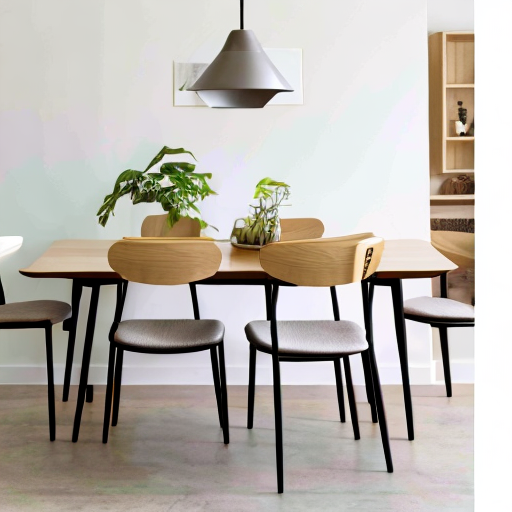

In [31]:
negative_prompt = "low quality, bad anatomy, bad quality, out of focus, ugly, worst quality, blury, bokeh, error"
generator = torch.manual_seed(-1)
image = pipe(
    "photo of a <new1> chair, near dining table, in dining room, natural, plants, comfortable, relaxing, super detailed",
    negative_prompt = negative_prompt,
    num_inference_steps=100,
    guidance_scale=5.0,
    generator=generator,
    eta=1.0,
).images[0]

display(image)